# Deep Zap-Q Learning

### Théo Moins - Yann Bouteiller - Dylan Troop

This notebook implements our adapted Deep Learning version of the Zap-Q Learning algorithm of Devraj and Meyn.

The code is a draft version adapted from the original Zap-Q learning python code that can be found at https://github.com/adidevraj .

In [0]:
# import libraries

import numpy as np
import random
from numpy.linalg import inv
from numpy.linalg import pinv
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import copy
import random
import math
import time

In [0]:
# This part of the code implements live plotting:

class PlotResults():
    def __init__(self):
        self.time = []
        self.data = []
        self.iteration = []
    
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict,
              title,
              ylabel=None,
              xlabel=None, figsize=(15,5),
              ylim1 = (0,200),
              clock_time1=True,
              data_dict2=None,
              ylabel2=None,
              xlabel2=None):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    if data_dict2:
        plt.subplot(1,2,1)
    for label,data in data_dict.items():
        if clock_time1:
            plt.plot(data.time,data.data,label=label)
        else:
            plt.plot(data.iteration,data.data,label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim1)
    plt.legend()
    if data_dict2:
        plt.subplot(1,2,2)
        for label,data in data_dict2.items():
            plt.plot(data.time,data.data,label=label)
        plt.title(title)
        plt.xlabel(xlabel2)
        plt.ylabel(ylabel2)
        plt.legend()
    plt.show();

## Implementation of Deep Zap-Q

In [0]:
# defining the graph (weighted with rewards):

R = torch.FloatTensor([[0,-100,-100,-100,-5,-100],
                    [-100,0,-100,-5,-100,100],
                    [-100,-100,0,-5,-100,-100],
                    [-100,-5,-5,0,-5,-100],
                    [-5,-100,-100,-5,0,100],
                    [-100,-5,-100,-100,-5,100]])

NumbertoSAPair = torch.IntTensor([[0, 0],[0,4],
                                  [1,1],[1,3],[1,5],
                                  [2,2],[2,3],
                                  [3,1],[3,2],[3,3],[3,4],
                                  [4,0],[4,3],[4,4],[4,5],
                                  [5,1],[5,4],[5,5]])

AlenVec = torch.IntTensor([2,3,2,4,4,3])

# Inverse mapping: Given state-action pair, what is the curresponding number:

SAPairtoNumber = -1*torch.ones((6,6), dtype=torch.int)

for i in range(len(NumbertoSAPair)):
    i1 = NumbertoSAPair[i,0].item()
    i2 = NumbertoSAPair[i,1].item()
    SAPairtoNumber[i1,i2]=i
    
StaActLen = torch.sum(AlenVec).item(); # Total number of state action pairs

# graph neighbors lists:

actionsList = []
actionsList.append(torch.IntTensor([0,4]))
actionsList.append(torch.IntTensor([1,3,5]))
actionsList.append(torch.IntTensor([2,3]))
actionsList.append(torch.IntTensor([1,2,3,4]))
actionsList.append(torch.IntTensor([0,3,4,5]))
actionsList.append(torch.IntTensor([1,4,5]))

In [0]:
def compute_Bellman_error(q_table, R, beta, noise):
    """
    Computes the maximal Bellman Error of a Q table wrt the adjacency matrix R
    This function is to be optimized later (use the neighbors list representation instead of this)
    """
    #Initialize Bellman error to 0:
    BE = torch.zeros(StaActLen) # initialiser BE_Zap avec des 0
    
    for jj in range(StaActLen): # pour tous les state-action possibles

        x = NumbertoSAPair[jj,0] # x = state
        a = NumbertoSAPair[jj,1] # a = action
        
        # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
        max_Qfun_xtp1_Zap = 0; # max_Qfun_xtp1_Zap initialisé à 0
        NumOfXtp1 = 0; # NumOfXtp1 initialisé à 0
        for ll in range(StaActLen): # pour tous les state-action possibles l
            if(NumbertoSAPair[ll,0] == x): # si l part de x
                xplus1 = NumbertoSAPair[ll,1] # xplus1 prend action
                max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + torch.max(q_table[xplus1]) # max_Qfun_xtp1_Zap += max q_table à partir de action
                NumOfXtp1 = NumOfXtp1 + 1 # NumOfXtp1++
        max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1 # max_Qfun_xtp1_Zap /= NumOfXtp1 (ie on prend l'average de toutes les greedy policies à partir de x)
        
        # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
        BE[jj] = R[x,a] + beta*((1-noise)*torch.max(q_table[a]) +  noise*max_Qfun_xtp1_Zap) - q_table[x,a]

    # MaximalBellmanError = max_{x,a} BE(x,a):  
    return torch.max(abs(BE))

In [0]:
def compute_max_real_part_eigenvalue(M): # computes the max real part of the eigenvalues of matrix M
    return np.max(np.real(np.linalg.eig(M)[0]))

In [0]:
def epsilon_greedy_policy(x, actionsList, Q, epsilon=0):
    """
    Returns action a (:= next wanted step in this problem)
    Takes greedy action with proba 1-epsilon
    actionsList is the list of lists of possible actions. Used to determine possible actions when environmentAwareness=True
    it will not be taken into account if environmentAwareness=False (then agent can choose -100 edges)
    Q is the Zap_Q neural net used to choose an action
    """
    
    # compute the best action
    def best_action():
        nb_actions=len(actionsList[x])
        Q_vals = torch.Tensor(nb_actions)
        for i in range(nb_actions):
            Q_vals[i] = Q.evaluateSA(x,actionsList[x][i])
        imax = torch.argmax(Q_vals)
        return actionsList[x][imax].item()
    
    r = np.random.rand()
    if r > epsilon:
        return best_action()
    else:
        return np.random.choice(actionsList[x])

In [0]:
def take_action(x, a, adjacencyMatrix, actionsList, randomness=0.5):
    """
    Environment response to the action a from state x, returns: newState, reward
    when environmentAwareness=True, only possible actions will be randomly taken in case of random failure
    """
    r = np.random.rand()
    if r > randomness:
        assert a in actionsList[x], "Error : the action in not possible"
        return a, adjacencyMatrix[x][a]
    else:
        aa = np.random.choice(actionsList[x])
        return aa, adjacencyMatrix[x][aa]

In [0]:
# Definition of our Deep Neural Network

class Q_function(nn.Module):
    def __init__(self, architecture = None):
        super(Q_function, self).__init__()
        
        if(architecture):
            self.net = architecture
        else:
            self.net = nn.Sequential(
                nn.Linear(StaActLen, 1, bias=False)
            )
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, 0)
    
    def input_size(self):
        return self.net.in_features
    
    def num_params(self):
        return sum(p.numel() for p in self.parameters())
        
    def forward(self, x):
        return self.net(x)
    
    def evaluate(self, x):
        with torch.no_grad():
            return self.net(x)
    
    def forwardSA(self, x, a): # to be improved: tensorize with lists of actions
        psixtat = torch.zeros(StaActLen)
        jj = SAPairtoNumber[x,a].item()
        psixtat[jj] = 1
        return self.forward(psixtat)
    
    def evaluateSA(self, x, a):
        with torch.no_grad():
            return self.forwardSA(x, a)
    
    def update_A_hat(self, A_hat, gammat, psixtat, psixtp1_OptAct, beta):
        giga_tensor = torch.Tensor()
        for f in self.parameters():
            self.zero_grad()
            forward1 = self.forward(psixtat)
            forward1.backward()
            grad1 = copy.deepcopy(f.grad)
            
            self.zero_grad()
            forward2 = self.forward(psixtp1_OptAct)
            forward2.backward()
            grad2 = copy.deepcopy(f.grad)

            giga_tensor = torch.cat((giga_tensor, (-grad1 + beta*grad2).view(-1)))
        
        A = torch.ger(psixtat, giga_tensor)
        
        A_hat = A_hat + gammat*(A - A_hat)

        return A_hat

    def update_parameters(self, A_hat, psixtat, alphat, dt):
        Ainv_ZapQ = torch.Tensor(np.linalg.pinv(A_hat.detach().numpy()))
        big_vector = alphat*(Ainv_ZapQ @ psixtat)*dt
        id = 0
        for f in self.parameters():
            f.data = f.data - big_vector[id : id + f.data.numel()].view(f.data.shape)
            id += f.data.numel()
    

In [0]:
# Zap Q algorithm:
def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None,
          plotLabel='Deep_Zap_Q',
          dataplot=None,
          architecture=None,
          ylim1=None):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    if not dataplot:
        dataplot = collections.defaultdict(PlotResults) # history of Bellman Errors to plot
    
    xt = xStart; # start in state 0
    noise = environmentRandomness
    
    Q = Q_function(architecture)
    
    # Initialize the Matrix gain for Zap Q:
    A_ZapQ = 10*torch.eye(StaActLen, Q.num_params())
    
    # Initialize the parameter vector for Zap Q:
    #Qthetat_ZapQ = torch.rand(StaActLen);

    # Initialize the Q function for Zap Q:
    Qfun_ZapQ = torch.zeros((6,6))

    # Q-learning begins here:
    
    start_time = time.time()
    
    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        #print('state:', xt)
        at = epsilon_greedy_policy(xt,
                                   actionsList,
                                   Q,
                                   epsilon=epsilon)
        #print('action:', at)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              actionsList,
                              randomness=environmentRandomness)
        #print('new state:', xtp1)


        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        #alphat = 0.001
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion

        num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psixtat = torch.zeros(StaActLen)
        psixtat[num_sa_pair] = 1 # Basis are indicator functions

        # Watkins' basis evaluated at next state and the optimal policy:
        # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
        Qxtp1_Zap = torch.zeros(StaActLen)
        for jj in range(6):
            if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
                psixtp1 = torch.zeros(StaActLen)
                ind = int(SAPairtoNumber[xtp1,jj])
                psixtp1[ind] = 1 # Take value 1
                Qxtp1_Zap[ind] = Q.evaluate(psixtp1)

        # Zap Q-learning step:

        # Q(X_t,A_t):
        Qxt_Zap = Q.evaluate(psixtat)
        #Qxt_Zap = torch.dot(Qthetat_ZapQ,psixtat)

        # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:

        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = torch.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:
        # max_Qxtp1_Zap = torch.max(Qxtp1_Zap)

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = torch.zeros(StaActLen);
        psixtp1_OptAct[OptAct_xtp1] = 1;
        
        max_Qxtp1_Zap = Q.evaluate(psixtp1_OptAct)

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        psixtat.requires_grad = True
        psixtp1_OptAct.requires_grad = True
        
        A_ZapQ = Q.update_A_hat(A_ZapQ, gammat, psixtat, psixtp1_OptAct, beta)
        

        # Q update for SNR 2 (a) gain:
        
        dt = R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap
        Q.update_parameters(A_ZapQ, psixtat, alphat, dt)
        
        #Q.state_dict() =  Q.state_dict()  - alphat*(Ainv_ZapQ @ psixtat)*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))
        #tmp = tmp - alphat*(Ainv_ZapQ @ psixtat)*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;

        # The code from here is to calculate the Bellman error at this iteration
        
        for jj in range(StaActLen):
                psixtat = torch.zeros(StaActLen)
                psixtat[jj] = 1
                Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Q.evaluate(psixtat)
        
        if((t%t_step)==0):
            # MaximalBellmanError = max_{x,a} BE(x,a):
            dataplot[plotLabel].time.append(time.time() - start_time)
            dataplot[plotLabel].iteration.append(t)
            dataplot[plotLabel].data.append(compute_Bellman_error(Qfun_ZapQ, R, beta, noise))
            if livePlot:
                live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='time (s)', ylim1=ylim1)

            # End of calculating Bellman Error
    return Qfun_ZapQ, dataplot

In [0]:
dataplot = collections.defaultdict(PlotResults)

In [168]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=0.9,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot = False,
          plotTitle='Deep Zap-Q with fully randomized policy: 1 layer, no non-linearity, one-hot of all SA',
          plotLabel='Deep_Zap_Q 1 layer random policy',
          dataplot=dataplot)

print(Q)

tensor([[306.0503,   0.0000,   0.0000,   0.0000, 373.5688,   0.0000],
        [  0.0000, 379.4550,   0.0000, 304.5229,   0.0000, 485.6285],
        [  0.0000,   0.0000, 231.1961, 283.2642,   0.0000,   0.0000],
        [  0.0000, 370.9597, 239.0391, 302.9702, 369.3605,   0.0000],
        [300.8424,   0.0000,   0.0000, 297.7938, 381.6313, 485.3987],
        [  0.0000, 382.9573,   0.0000,   0.0000, 383.6984, 493.9119]])


In [169]:
architecture = nn.Sequential(
    nn.Linear(StaActLen, 1, bias=False)
)
for m in architecture.modules():
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot = False,
          plotTitle='Deep Zap-Q with fully randomized policy: 1 layer, no non-linearity, one-hot of all SA',
          dataplot=dataplot,
          plotLabel='Deep_Zap-Q 1 layer 0.5greedy policy',
          architecture = architecture)

print(Q)

tensor([[293.6740,   0.0000,   0.0000,   0.0000, 364.6186,   0.0000],
        [  0.0000, 382.1351,   0.0000, 299.6319,   0.0000, 485.3008],
        [  0.0000,   0.0000, 228.9740, 280.6144,   0.0000,   0.0000],
        [  0.0000, 354.8618, 230.8902, 302.5412, 364.9513,   0.0000],
        [295.4068,   0.0000,   0.0000, 294.3305, 370.8096, 479.5942],
        [  0.0000, 382.9561,   0.0000,   0.0000, 379.4745, 491.2934]])


In [170]:
architecture = nn.Sequential(
    nn.Linear(StaActLen, 1, bias=False)
)
for m in architecture.modules():
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=0.9,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot = False,
          plotTitle='Deep Zap-Q 1 layer, no non-linearity, one-hot of all SA',
          dataplot=dataplot,
          plotLabel='Deep_Zap-Q 1 layer 0.9greedy policy',
          architecture = architecture)

print(Q)

tensor([[314.8618,   0.0000,   0.0000,   0.0000, 377.3702,   0.0000],
        [  0.0000, 381.5335,   0.0000, 306.3166,   0.0000, 487.9135],
        [  0.0000,   0.0000, 234.0153, 286.9910,   0.0000,   0.0000],
        [  0.0000, 371.4743, 247.3040, 305.2726, 375.4065,   0.0000],
        [304.5002,   0.0000,   0.0000, 304.1476, 381.0946, 487.6412],
        [  0.0000, 385.1359,   0.0000,   0.0000, 385.5655, 494.7191]])


In [171]:
architecture = nn.Sequential(
    nn.Linear(StaActLen, 1, bias=False)
)
for m in architecture.modules():
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=-1,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot = False,
          plotTitle='Deep Zap-Q 1 layer',
          dataplot=dataplot,
          plotLabel='Deep_Zap-Q 1 layer 1/tgreedy policy',
          ylim1=None,
          architecture = architecture)

print(Q)

tensor([[-1.9516e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.9648e+02,
          0.0000e+00],
        [ 0.0000e+00, -4.9869e-12,  0.0000e+00, -2.4351e+01,  0.0000e+00,
          2.6302e+02],
        [ 0.0000e+00,  0.0000e+00, -8.1293e+00, -2.4897e+01,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  1.7736e+02, -2.0440e+01, -2.6351e+01, -3.1391e+01,
          0.0000e+00],
        [-3.1780e+01,  0.0000e+00,  0.0000e+00, -3.0498e+01,  9.1904e+01,
          2.6269e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0172e+02,
         -3.4997e+01]])


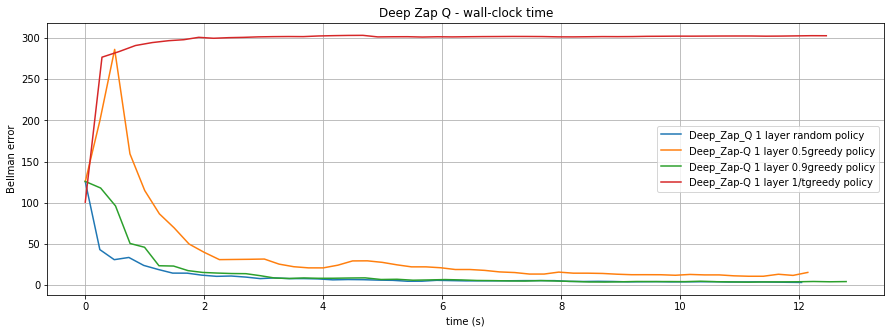

In [172]:
live_plot(dataplot, title='Deep Zap Q - wall-clock time', ylabel='Bellman error', xlabel='time (s)', ylim1=None)

## Implementation of vanilla Zap Q

In [0]:
# defining the graph (weighted with rewards):

R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])

NumbertoSAPair = np.array([[0, 0],[0,4],
                           [1,1],[1,3],[1,5],
                           [2,2],[2,3],[3,1],[3,2],[3,3],
                           [3,4],[4,0],[4,3],[4,4],[4,5],
                           [5,1],[5,4],[5,5]])

AlenVec = np.array([2,3,2,4,4,3])

# Inverse mapping: Given state-action pair, what is the curresponding number:
SAPairtoNumber = -1*np.ones((6,6))

for i in range(len(NumbertoSAPair)):
    SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
    
StaActLen = np.sum(AlenVec); # Total number of state action pairs

In [0]:
def compute_Bellman_error(q_table, beta, noise):

    #Initialize Bellman error to 0:
    BE = np.zeros(StaActLen) # initialiser BE_Zap avec des 0
    
    for jj in range(StaActLen): # pour tous les state-action possibles

        x = NumbertoSAPair[jj,0] # x = state(jj)
        a = NumbertoSAPair[jj,1] # a = action(jj)

        # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
        max_Qfun_xtp1_Zap = 0; # max_Qfun_xtp1_Zap initialisé à 0
        NumOfXtp1 = 0; # NumOfXtp1 initialisé à 0
        for ll in range(StaActLen): # pour tous les state-action possibles ll
            if(NumbertoSAPair[ll,0] == x): # si ll part de state(jj)
                xplus1 = NumbertoSAPair[ll,1] # xplus1 prend action(ll)
                max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + np.max(q_table[xplus1]) # max_Qfun_xtp1_Zap += max q_table à partir de action(ll)
                NumOfXtp1 = NumOfXtp1 + 1 # NumOfXtp1++
        max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1 # max_Qfun_xtp1_Zap /= NumOfXtp1 (ie on prend l'average de toutes les greedy policies à partir de x)

        # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
        BE[jj] = R[x,a] + beta*((1-noise)*np.max(q_table[a]) +  noise*max_Qfun_xtp1_Zap) - q_table[x,a]

    # MaximalBellmanError = max_{x,a} BE(x,a):  
    return np.max(abs(BE))

In [0]:
import math

def epsilon_greedy_policy(x, adjacencyMatrix, QTable, epsilon=0, environmentAwareness=False):
    """
    Returns action a (:= next wanted step in this problem)
    Takes greedy action with proba 1-epsilon
    adjacencyMatrix is the weighted reward matrix with -100 where no edges
    it will not be taken into account if environmentAwareness=False (then agent can choose -100 edges)
    """
    r = np.random.rand()
    if not environmentAwareness:
        if r > epsilon:
            return np.argmax(QTable[x])
        else:
            return np.random.choice(range(QTable[x].shape[0]))
    else:
        if r > epsilon:
            imax = -1
            Qmax = -1 * math.inf
            for i in range(QTable[x].shape[0]):
                if adjacencyMatrix[x][i] > -100 and QTable[x][i] > Qmax:
                    imax = i
                    Qmax = QTable[x][i]
            assert imax > -1, "Error : no possible action"
            return imax
        
        else:
            available = []
            for i in range(adjacencyMatrix[x].shape[0]):
                if adjacencyMatrix[x][i] > -100:
                    available.append(i)
            assert not len(available) == 0, "Error : no possible action"
            return np.random.choice(available)

In [0]:
def take_action(x, a, adjacencyMatrix, environmentAwareness=True, randomness=0.5):
    """
    Environment response to the action a from state x, returns: newState, reward
    when environmentAwareness=True, only possible actions will be randomly taken in case of random failure
    """
    #print('randomness:', randomness, 'received x:', x, 'received a:', a)
    r = np.random.rand()
    if not environmentAwareness:
        if r > randomness:
            #print('not environmentAwareness, r > rand')
            return a, adjacencyMatrix[x][a]
        else:
            #print('not environmentAwareness, r <= rand')
            aa = np.random.choice(range(adjacencyMatrix[x].shape[0]))
            return aa, adjacencyMatrix[x][aa]
    else:
        available = []
        for i in range(adjacencyMatrix[x].shape[0]):
            if adjacencyMatrix[x][i] > -100:
                available.append(i)
        assert not len(available) == 0, "Error : no possible action"
        if r > randomness:
            assert a in available, "Error : the action in not possible"
            #print('environmentAwareness, r > rand')
            return a, adjacencyMatrix[x][a]
        else:
            #print('environmentAwareness, r <= rand')
            aa = np.random.choice(available)
            return aa, adjacencyMatrix[x][aa]

In [0]:
def compute_max_real_part_eigenvalue(M): # computes the max real part of the eigenvalues of matrix M
    return np.max(np.real(np.linalg.eig(M)[0]))

In [0]:
# Zap Q algorithm:
def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None,
          plotLabel='Zap_Q',
          dataplot=None,
          ylim1=None):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    if not dataplot:
        dataplot = collections.defaultdict(PlotResults) # history of Bellman Errors to plot
    #dataplot2 = collections.defaultdict(list) # history of max eigenvalues of GA to plot
    
    xt = xStart; # start in state 0
    noise = environmentRandomness
    R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])
    
    AlenVec = np.array([2,3,2,4,4,3]) # Number of actions in each state; Ex: 2 = number of actions in state 0.

    # We need a mapping from state-action pair to a number between 1 and 18
    # This array is precisely that mapping
    # E.g. [State 0, Action 0] corresponds to the zeroeth state-action pair, 
    # [State 0, Action 4] corresponds to the first state-action pair

    NumbertoSAPair = np.array([[0, 0],[0,4],[1,1],[1,3],[1,5],
                               [2,2],[2,3],[3,1],[3,2],[3,3],
                               [3,4],[4,0],[4,3],[4,4],[4,5],
                               [5,1],[5,4],[5,5]])

    # Location of the state-action pair indicates the unique number which represents this pair (e.g. [5 5] = 17)

    # Inverse mapping: Given state-action pair, what is the curresponding number:
    SAPairtoNumber = -1*np.ones((6,6))

    for i in range(len(NumbertoSAPair)):
        SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
        
    StaActLen = np.sum(AlenVec); # Total number of state action pairs

    # Initialize the Matrix gain for Zap Q:
    A_ZapQ = 10*np.eye(StaActLen)

    # Initialize the parameter vector for Zap Q:
    Qthetat_ZapQ = np.random.rand(StaActLen);

    # Initialize the Q function for Zap Q:
    Qfun_ZapQ = np.zeros((6,6))

    # Q-learning begins here:
    
    start_time = time.time()
    
    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        # ChooseAction will return the random action chosen in the current state AND the next state
        #xtp1at_m = ChooseAction(xt,noise,Qfun_ZapQ)
        at = epsilon_greedy_policy(xt,
                                   R,
                                   Qfun_ZapQ,
                                   epsilon=epsilon,
                                   environmentAwareness=policyEnvironmentAwareness)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              environmentAwareness=environmentEnvironmentAwareness,
                              randomness=environmentRandomness)
        #print(at)
        #print(xtp1)
        #break

        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion

        num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psixtat = np.zeros(StaActLen)
        psixtat[num_sa_pair] = 1; # Basis are indicator functions

        # Watkins' basis evaluated at next state and the optimal policy:
        # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
        psixtp1 = np.zeros(StaActLen)
        for jj in range(6):
            if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
                psixtp1[int(SAPairtoNumber[xtp1,jj])] = 1 # Take value 1


        # Zap Q-learning step:

        # Q(X_t,A_t):
        Qxt_Zap = np.dot(Qthetat_ZapQ,psixtat)

        # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:
        Qxtp1_Zap = np.multiply(Qthetat_ZapQ,psixtp1)

        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = np.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:
        max_Qxtp1_Zap = np.max(Qxtp1_Zap)
        # max_Qxtp1_Zap = Qxtp1_Zap[OptAct_xtp1]

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = np.zeros(StaActLen);
        psixtp1_OptAct[OptAct_xtp1] = 1;

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        A_ZapQ = A_ZapQ + gammat*( ( - np.outer(psixtat,psixtat) + beta*np.outer(psixtat,psixtp1_OptAct)) - A_ZapQ)
        Ainv_ZapQ = np.linalg.pinv(A_ZapQ)

        # Q update for SNR 2 (a) gain:
        Qthetat_ZapQ  =  Qthetat_ZapQ  - alphat*(np.dot(Ainv_ZapQ,psixtat))*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;

        # The code from here is to calculate the Bellman error at this iteration
        
        for jj in range(StaActLen):
            Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Qthetat_ZapQ[jj]
        
        if((t%t_step)==0):
            # MaximalBellmanError = max_{x,a} BE(x,a):  
            dataplot[plotLabel].time.append(time.time() - start_time)
            dataplot[plotLabel].iteration.append(t)
            dataplot[plotLabel].data.append(compute_Bellman_error(Qfun_ZapQ, beta, noise))
            #dataplot2['Zap_Q'].append(compute_max_real_part_eigenvalue(A_ZapQ))
            #dataplotMaxEV['Zap_Q'].append(compute_max_real_part_eigenvalue())
            if livePlot:
                live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='time (s)', ylim1=ylim1)

            # End of calculating Bellman Error
    #if not livePlot:
    #    live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return Qfun_ZapQ, dataplot

In [179]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          dataplot=dataplot)

print(Q)

[[306.23342518   0.           0.           0.         373.74958878
    0.        ]
 [  0.         379.92687281   0.         303.69423892   0.
  484.29549178]
 [  0.           0.         235.81167311 283.5688905    0.
    0.        ]
 [  0.         372.91678103 239.96338436 304.95513549 366.55934222
    0.        ]
 [303.39491464   0.           0.         301.97968149 377.10131049
  482.68928607]
 [  0.         382.71332988   0.           0.         381.55076977
  490.8583365 ]]


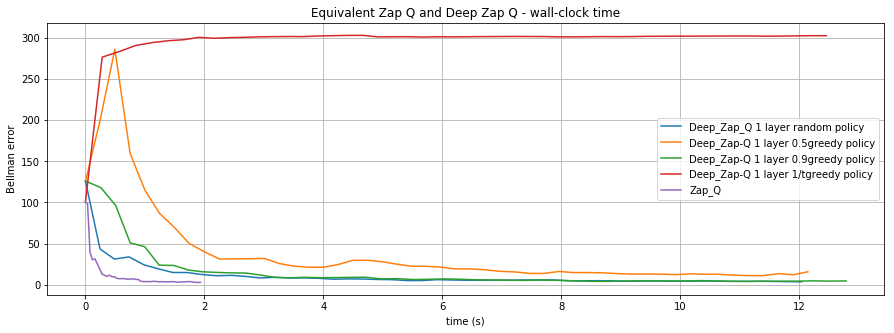

In [180]:
live_plot(dataplot, title='Equivalent Zap Q and Deep Zap Q - wall-clock time', ylabel='Bellman error', xlabel='time (s)', ylim1=None)

## Implementation of vanilla Q learning

In [0]:
# vanilla Q learning :

def vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 100000,
                       iter_max = 10,
                       policyRandomness = 0,
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       seed=0,
                       plotTitle=None,
                       dataplot=None,
                       plotLabel='Vanilla_Q'):
    np.random.seed(seed)
    BE = np.zeros((6,6))
    xt1 = 4
    if not dataplot:
        dataplot = collections.defaultdict(PlotResults)
    #dataplot = collections.defaultdict(list)
    #print ('----- using Q Learning -----')
    q_table = np.zeros((6,6))
    start_time = time.time()
    for i in range(iter_max):
        obs = xt1
        total_reward = 0
        for j in range(t_max):
            #alpha = 1/(j+1)
            alpha = max(min_lr, initial_lr * (0.85 ** (j//100)))
            xt0 = xt1
            #print('---\n state ', xt0)
            #print('qtable initiale \n', q_table)
            action = epsilon_greedy_policy(xt0,
                                   R,
                                   q_table,
                                   epsilon=policyRandomness,
                                   environmentAwareness=policyEnvironmentAwareness)
            #print('chosen action ', action)
            xt1, reward = take_action(xt0,
                                  action,
                                  R,
                                  environmentAwareness=environmentEnvironmentAwareness,
                                  randomness=environmentRandomness)
            #print('new state ', xt1, ', reward ', reward)
            total_reward += (gamma ** j) * reward
            # update q table
            q_table[xt0][action] = q_table[xt0][action] + alpha * (reward + gamma *  np.max(q_table[xt1]) - q_table[xt0][action])
            #print('qtable updated \n', q_table)
            if j%10000 == 0:
                dataplot[plotLabel].data.append(compute_Bellman_error(q_table, gamma, environmentRandomness))
                dataplot[plotLabel].iteration.append(i*t_max + j)
                dataplot[plotLabel].time.append(time.time() - start_time)
                if livePlot:
                    live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return q_table, dataplot

In [182]:
q_table, dataplot = vanilla_Q_learning(livePlot=False,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 500000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 1, # full random
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       plotTitle='Vanilla Q Learning - random policy',
                       dataplot = dataplot)

print(q_table)

[[265.05046086   0.           0.           0.         323.36245426
    0.        ]
 [  0.         339.91423031   0.         273.2508229    0.
  420.57926363]
 [  0.           0.         204.793601   248.2731681    0.
    0.        ]
 [  0.         322.22303005 212.60435261 262.78106924 316.53167372
    0.        ]
 [266.8360271    0.           0.         267.84377018 331.28701497
  414.76390338]
 [  0.         339.9857719    0.           0.         339.32454816
  423.97578992]]


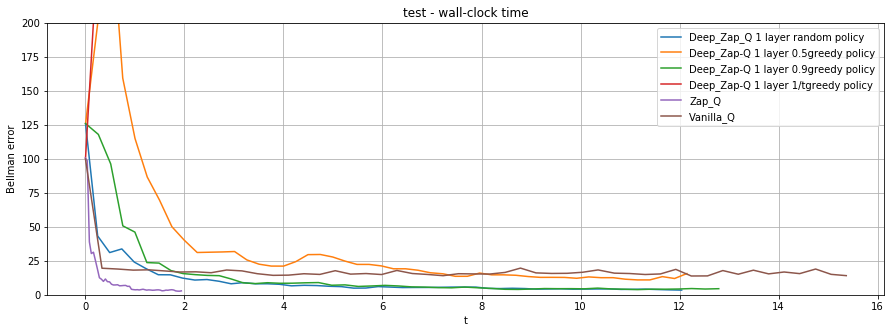

In [183]:
live_plot(dataplot, title='test - wall-clock time', ylabel='Bellman error', xlabel='t')

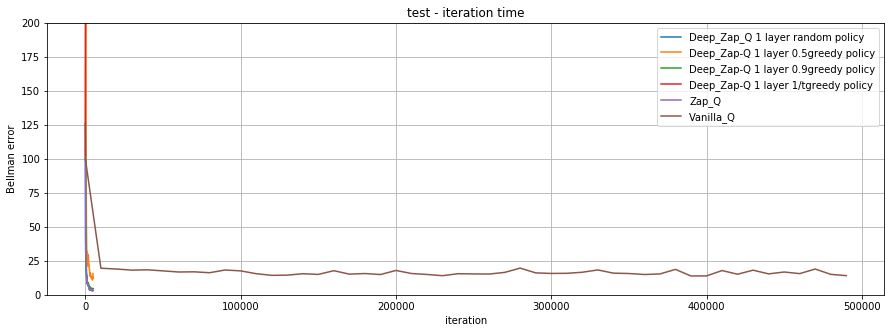

In [184]:
live_plot(dataplot, title='test - iteration time', ylabel='Bellman error', xlabel='iteration',clock_time1=False)